In [ ]:
#!pip install pandas==2.1.1
#!pip install scorecardpy==0.1.9.7

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import pandas as pd, numpy as np
pd.options.mode.chained_assignment = None
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn import linear_model, metrics
import scorecardpy as sc
import pprint
import seaborn as sns

In [2]:
bureau_data=pd.read_csv('IS453 Group Assignment - Bureau Data.csv')
application_data=pd.read_csv('IS453 Group Assignment - Application Data.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'IS453 Group Assignment - Bureau Data.csv'

In [ ]:
# choosing columns to keep 
application_data_cleaned = application_data[['SK_ID_CURR', 'TARGET', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
                                            'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
                                            'NAME_INCOME_TYPE', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_CONT_MOBILE',
                                            'CNT_FAM_MEMBERS', 'REG_REGION_NOT_LIVE_REGION', 'EXT_SOURCE_1', 'AMT_REQ_CREDIT_BUREAU_MON']].copy()

bureau_data_cleaned = bureau_data[['SK_ID_CURR', 'SK_ID_BUREAU', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_DAY_OVERDUE', 'AMT_CREDIT_MAX_OVERDUE',
                                  'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_OVERDUE',
                                  'CREDIT_TYPE', 'DAYS_CREDIT_UPDATE', 'AMT_ANNUITY']].copy()

own_car_mask = application_data_cleaned['FLAG_OWN_CAR'] == 'N'
app_filtered = application_data_cleaned.loc[
    own_car_mask, application_data_cleaned.columns.difference(['FLAG_OWN_CAR'])
].copy()

bureau_filtered = bureau_data_cleaned.loc[
    (bureau_data_cleaned['CREDIT_CURRENCY'] == 'currency 1') & 
    (bureau_data_cleaned['CREDIT_TYPE'] != 'Car loan'),
    bureau_data_cleaned.columns.difference(['CREDIT_CURRENCY'])
].copy()

bureau_aggregated = bureau_filtered.groupby('SK_ID_CURR').agg({
    'SK_ID_BUREAU': 'count',  # Number of past loans
    'CREDIT_ACTIVE': lambda x: x.value_counts().idxmax(),  # Most frequent credit status
    'CREDIT_DAY_OVERDUE': 'mean',  # Average overdue days
    'AMT_CREDIT_MAX_OVERDUE': 'max',  # Max overdue amount
    'CNT_CREDIT_PROLONG': 'sum',  # Total prolongations
    'AMT_CREDIT_SUM': 'sum',  # Total outstanding credit
    'AMT_CREDIT_SUM_DEBT': 'mean',  # Average current debt
    'AMT_CREDIT_SUM_OVERDUE': 'max',  # Max overdue amount
    'CREDIT_TYPE': lambda x: x.value_counts().idxmax(),  # Most frequent credit type
    'DAYS_CREDIT_UPDATE': 'min',  # Most recent credit update
    'AMT_ANNUITY': 'mean',  # Average annuity payment
}).reset_index()

bureau_aggregated.rename(columns={"SK_ID_BUREAU": "CREDIT_COUNT"}, inplace=True)
bureau_aggregated['OVERDUE_CREDIT_COUNT'] = bureau_filtered[bureau_filtered['CREDIT_DAY_OVERDUE'] > 0].groupby('SK_ID_CURR')['SK_ID_BUREAU'].transform('count')
merged_data = app_filtered.merge(bureau_aggregated, on='SK_ID_CURR', how='left')



In [4]:
# number of rows
# rows = merged_data.shape[0]
# print(f"Number of rows after selection: {rows}")

# calculate percentage of bad loans after filtering
# total_loans = len(app_filtered)
# bad_loans = app_filtered[app_filtered['TARGET'] == 1].shape[0]
# print(f"Number of Bad Loans after selection:{bad_loans}")
# bad_loans_percentage = (bad_loans / total_loans) * 100
# print(f"Percentage of Bad Loans after filtering: {bad_loans_percentage:.2f}%")

# # calculate percentage of bad loans in orig dataset
# total_loans = len(application_data_cleaned)
# bad_loans = application_data_cleaned[application_data_cleaned['TARGET'] == 1].shape[0]
# bad_loans_percentage = (bad_loans / total_loans) * 100
# print(f"Percentage of Bad Loans in orig dataset: {bad_loans_percentage:.2f}%")

## helper functions

In [30]:
def get_iv(bins):
    iv_dict = {key: df["total_iv"].iloc[0] for key, df in bins.items()}
    return iv_dict

In [31]:
def remove_low_iv_columns(train_data, test_data, bins, min_iv):
    iv_dict = get_iv(bins)
    sorted_iv = sorted(iv_dict.items(), key=lambda x: x[1], reverse=True)
    top_iv_columns = [variable[0] for variable in sorted_iv if variable[1] >= min_iv]
    if 'TARGET' not in top_iv_columns:
        top_iv_columns += ['TARGET']
    return train_data[top_iv_columns], test_data[top_iv_columns]

In [32]:
def remove_high_corr_columns(train_woe, test_woe, cor_threshold):
    correlation_matrix = train_woe.corr()
    high_correlation_pairs = correlation_matrix.where(np.abs(correlation_matrix) > cor_threshold).stack().reset_index()
    high_correlation_pairs.columns = ['Feature_1', 'Feature_2', 'Correlation']
    high_correlation_pairs = high_correlation_pairs[high_correlation_pairs['Feature_1'] != high_correlation_pairs['Feature_2']]
    high_correlation_pairs['Pair'] = high_correlation_pairs.apply(lambda row: frozenset([row['Feature_1'], row['Feature_2']]), axis=1)
    high_correlation_pairs = high_correlation_pairs.drop_duplicates(subset='Pair').drop(columns=['Pair'])

    iv_dict = get_iv(bins)
    columns_to_drop = []
    for index, row in high_correlation_pairs.iterrows():
        if iv_dict[row['Feature_1'][:-4]] >= iv_dict[row['Feature_2'][:-4]]:
            columns_to_drop += [row['Feature_2']]
        else:
            columns_to_drop += [row['Feature_1']]
    
    train_woe = train_woe.drop(columns_to_drop, axis=1)
    test_woe = test_woe.drop(columns_to_drop, axis=1)
    
    return train_woe, test_woe

## working code

### create scorecard

In [81]:
working_data = merged_data.copy()
working_data = working_data.drop(columns=['FLAG_MOBIL', 'SK_ID_CURR'])
train, test = sc.split_df(working_data, y = 'TARGET', ratio = .7).values()
# train = train.copy()
# test = test.copy()
bins = sc.woebin(train, y = 'TARGET')

min_iv = 0.02
train, test = remove_low_iv_columns(train, test, bins, min_iv)

train_woe = sc.woebin_ply(train, bins)
test_woe = sc.woebin_ply(test, bins)

max_corr = 0.5
train_woe, test_woe = remove_high_corr_columns(train_woe, test_woe, max_corr)

y_train = train_woe.loc[:, 'TARGET']
X_train = train_woe.loc[:, train_woe.columns != 'TARGET']
y_test = test_woe.loc[:, 'TARGET']
X_test = test_woe.loc[:, train_woe.columns != 'TARGET']
lr = linear_model.LogisticRegression(class_weight='balanced')
lr.fit(X_train, y_train)
pd.Series(np.concatenate([lr.intercept_, lr.coef_[0]]),
          index = np.concatenate([['intercept'], lr.feature_names_in_]) )
card = sc.scorecard(bins, lr, X_train.columns, points0 = 600, odds0 = 1/19, pdo = 20, basepoints_eq0 = True)
print("scorecard generation completed")

[INFO] creating woe binning ...
Binning on 142046 rows and 26 columns in 00:00:19
[INFO] converting into woe values ...
[INFO] converting into woe values ...
scorecard generation completed


### test scorecard performance

In [82]:

train_score = sc.scorecard_ply(train.copy(), card)
test_score = sc.scorecard_ply(test.copy(), card)
# 10:1 of default 
# cutoff = 580

# 5:1 of default
# cutoff = 560

# 2.5:1 of default
cutoff = 540

# 1.76:1 of default
# cutoff = 530

# 0.625:1 of default
# cutoff = 500

# create sets of predicted bad to compare with actual bad
predicted_bad_train = (train_score < cutoff)
predicted_bad_train_list = predicted_bad_train.astype(int).values.flatten().tolist()
predicted_bad_test = (test_score < cutoff)
predicted_bad_test_list = predicted_bad_test.astype(int).values.flatten().tolist()

print('*** Training Data Performance ***')
print('Confusion matrix:')
print(metrics.confusion_matrix(y_train, predicted_bad_train_list))
print('PCC measures:')
print(metrics.classification_report(y_train, predicted_bad_train_list))

print('*** Test Data Performance ***')
print('Confusion matrix:')
print(metrics.confusion_matrix(y_test, predicted_bad_test_list))
print('PCC measures:')
print(metrics.classification_report(y_test, predicted_bad_test_list))

*** Training Data Performance ***
Confusion matrix:
[[ 18395 111577]
 [   596  11478]]
PCC measures:
              precision    recall  f1-score   support

           0       0.97      0.14      0.25    129972
           1       0.09      0.95      0.17     12074

    accuracy                           0.21    142046
   macro avg       0.53      0.55      0.21    142046
weighted avg       0.89      0.21      0.24    142046

*** Test Data Performance ***
Confusion matrix:
[[ 7816 47887]
 [  242  4933]]
PCC measures:
              precision    recall  f1-score   support

           0       0.97      0.14      0.25     55703
           1       0.09      0.95      0.17      5175

    accuracy                           0.21     60878
   macro avg       0.53      0.55      0.21     60878
weighted avg       0.90      0.21      0.24     60878



Cutoff score of 540: 15,981 applications approved (11.3%)


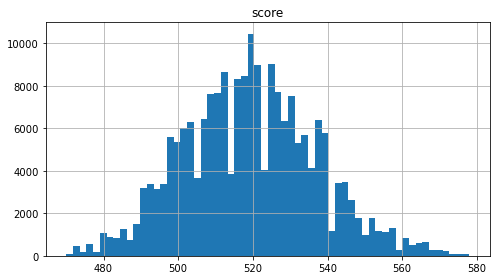

In [68]:
# combine scores for train and test data to assess distribution for entire population
combined_score = pd.concat([train_score, test_score], ignore_index=True)

# plot distribution of scores on copmbined data
combined_score.hist(figsize = (7, 4), bins = 60)
plt.tight_layout()

approval_count = train_score[train_score["score"]>cutoff].count()['score']
approval_rate = approval_count/train_score.shape[0]
print(f'Cutoff score of {cutoff:.0f}: {approval_count:,.0f} applications approved ({approval_rate:.1%})')

In [69]:
###### sample code

# calculate expected number of defaults
odds_at_cutoff = 2.5

default_prob = 1/(1+odds_at_cutoff)
defaults = default_prob*approval_count
print(f'Cutoff score of {cutoff:.0f}: {defaults:.0f} defaults expected')

Cutoff score of 540: 4566 defaults expected


In [70]:
pprint.pprint(card)

{'AMT_CREDIT_SUM_DEBT':                variable                 bin  points
38  AMT_CREDIT_SUM_DEBT             missing    70.0
39  AMT_CREDIT_SUM_DEBT      [-inf,20000.0)    81.0
40  AMT_CREDIT_SUM_DEBT   [20000.0,80000.0)    73.0
41  AMT_CREDIT_SUM_DEBT  [80000.0,300000.0)    69.0
42  AMT_CREDIT_SUM_DEBT      [300000.0,inf)    72.0,
 'AMT_GOODS_PRICE':            variable                   bin  points
66  AMT_GOODS_PRICE               missing    81.0
67  AMT_GOODS_PRICE       [-inf,150000.0)    79.0
68  AMT_GOODS_PRICE   [150000.0,300000.0)    73.0
69  AMT_GOODS_PRICE   [300000.0,500000.0)    67.0
70  AMT_GOODS_PRICE   [500000.0,900000.0)    75.0
71  AMT_GOODS_PRICE  [900000.0,1100000.0)    81.0
72  AMT_GOODS_PRICE       [1100000.0,inf)    85.0,
 'CREDIT_ACTIVE':          variable            bin  points
90  CREDIT_ACTIVE        missing    71.0
91  CREDIT_ACTIVE         Closed    77.0
92  CREDIT_ACTIVE  Active%,%Sold    70.0,
 'DAYS_CREDIT_UPDATE':               variable              